In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, models
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import time
import copy
from tqdm import tqdm

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [8]:
# Dataset path
DATASET_PATH = r"D:\gloucoma"
IMAGES_PATH = os.path.join(DATASET_PATH, "Images")
CSV_FILE = os.path.join(DATASET_PATH, "G1020.csv")

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.0001
NUM_CLASSES = 2
CLASS_NAMES = ['normal', 'glaucoma']

print(f"Dataset path: {DATASET_PATH}")
print(f"Images path: {IMAGES_PATH}")
print(f"CSV file: {CSV_FILE}")

Dataset path: D:\gloucoma
Images path: D:\gloucoma\Images
CSV file: D:\gloucoma\G1020.csv


In [9]:
# Load CSV
df = pd.read_csv(CSV_FILE)
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

# Add image paths
df['image_path'] = df['imageID'].apply(lambda x: os.path.join(IMAGES_PATH, x))

# Check if images exist
df['exists'] = df['image_path'].apply(os.path.exists)
print(f"\nImages found: {df['exists'].sum()} / {len(df)}")

# Keep only existing images
df = df[df['exists']].copy()
df = df.drop('exists', axis=1)

print(f"\nLabel distribution:")
print(df['binaryLabels'].value_counts())

Dataset shape: (1020, 2)

First few rows:
       imageID  binaryLabels
0  image_0.jpg             0
1  image_1.jpg             0
2  image_3.jpg             0
3  image_4.jpg             0
4  image_5.jpg             0

Images found: 1020 / 1020

Label distribution:
binaryLabels
0    724
1    296
Name: count, dtype: int64


In [10]:
# Split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['binaryLabels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['binaryLabels'], random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 714
Validation samples: 153
Test samples: 153


In [11]:
class GlaucomaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'image_path']
        label = self.dataframe.loc[idx, 'binaryLabels']
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

print("Dataset class created!")

Dataset class created!


In [12]:
# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = GlaucomaDataset(train_df, transform=train_transform)
val_dataset = GlaucomaDataset(val_df, transform=val_transform)
test_dataset = GlaucomaDataset(test_df, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 23
Validation batches: 5
Test batches: 5


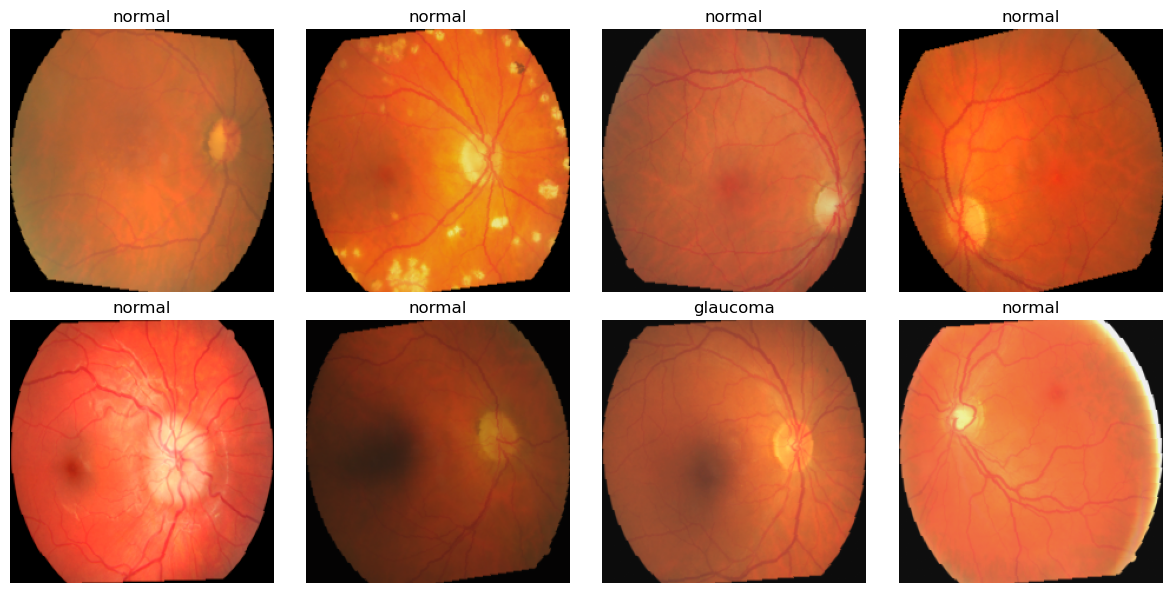

In [13]:
# Get a batch of images
images, labels = next(iter(train_loader))

# Denormalize for visualization
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Plot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(CLASS_NAMES[labels[i]])
        ax.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Load pretrained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modify the final layer for our classes
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, NUM_CLASSES)
)

model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 24,558,146
Trainable parameters: 24,558,146


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [16]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / total, correct / total, all_preds, all_labels

print("Training functions defined!")

Training functions defined!


In [17]:
# Training history
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_acc = 0.0
best_model_wts = None

print("Starting training...\n")

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print("-" * 40)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    
    # Validate
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"✓ New best model saved! Accuracy: {val_acc:.4f}")
    
    print()

print(f"Training complete! Best validation accuracy: {best_acc:.4f}")

Starting training...

Epoch 1/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.68s/it]


Train Loss: 0.6405 | Train Acc: 0.6919
Val Loss: 0.6542 | Val Acc: 0.6863
✓ New best model saved! Accuracy: 0.6863

Epoch 2/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.40s/it]


Train Loss: 0.6356 | Train Acc: 0.7045
Val Loss: 0.6504 | Val Acc: 0.6797

Epoch 3/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.40s/it]


Train Loss: 0.5997 | Train Acc: 0.7115
Val Loss: 0.6149 | Val Acc: 0.7059
✓ New best model saved! Accuracy: 0.7059

Epoch 4/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.42s/it]


Train Loss: 0.5875 | Train Acc: 0.7129
Val Loss: 0.6098 | Val Acc: 0.7059

Epoch 5/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.48s/it]


Train Loss: 0.5760 | Train Acc: 0.7227
Val Loss: 0.6633 | Val Acc: 0.6601

Epoch 6/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.43s/it]


Train Loss: 0.5592 | Train Acc: 0.7227
Val Loss: 0.6517 | Val Acc: 0.6993

Epoch 7/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.48s/it]


Train Loss: 0.5462 | Train Acc: 0.7269
Val Loss: 0.6904 | Val Acc: 0.7255
✓ New best model saved! Accuracy: 0.7255

Epoch 8/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.42s/it]


Train Loss: 0.5312 | Train Acc: 0.7381
Val Loss: 0.6908 | Val Acc: 0.6797

Epoch 9/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.24s/it]


Train Loss: 0.5016 | Train Acc: 0.7451
Val Loss: 0.7496 | Val Acc: 0.6797

Epoch 10/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.23s/it]


Train Loss: 0.4464 | Train Acc: 0.8011
Val Loss: 0.7396 | Val Acc: 0.6078

Epoch 11/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.21s/it]


Train Loss: 0.4085 | Train Acc: 0.8207
Val Loss: 0.8439 | Val Acc: 0.6340

Epoch 12/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.25s/it]


Train Loss: 0.3676 | Train Acc: 0.8333
Val Loss: 1.0610 | Val Acc: 0.6667

Epoch 13/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.26s/it]


Train Loss: 0.3282 | Train Acc: 0.8529
Val Loss: 0.8770 | Val Acc: 0.6013

Epoch 14/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.18s/it]


Train Loss: 0.2856 | Train Acc: 0.8950
Val Loss: 0.9753 | Val Acc: 0.5686

Epoch 15/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.27s/it]


Train Loss: 0.2449 | Train Acc: 0.9160
Val Loss: 0.9757 | Val Acc: 0.5686

Epoch 16/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.28s/it]


Train Loss: 0.2013 | Train Acc: 0.9244
Val Loss: 1.1043 | Val Acc: 0.5294

Epoch 17/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.22s/it]


Train Loss: 0.1677 | Train Acc: 0.9468
Val Loss: 1.1735 | Val Acc: 0.5882

Epoch 18/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.22s/it]


Train Loss: 0.1590 | Train Acc: 0.9482
Val Loss: 1.1768 | Val Acc: 0.5752

Epoch 19/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.23s/it]


Train Loss: 0.1654 | Train Acc: 0.9412
Val Loss: 1.1756 | Val Acc: 0.5752

Epoch 20/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.53s/it]


Train Loss: 0.1453 | Train Acc: 0.9454
Val Loss: 1.2052 | Val Acc: 0.6144

Epoch 21/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.77s/it]


Train Loss: 0.1193 | Train Acc: 0.9650
Val Loss: 1.2473 | Val Acc: 0.5752

Epoch 22/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.63s/it]


Train Loss: 0.1205 | Train Acc: 0.9538
Val Loss: 1.2966 | Val Acc: 0.5948

Epoch 23/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.39s/it]


Train Loss: 0.1287 | Train Acc: 0.9580
Val Loss: 1.3099 | Val Acc: 0.5752

Epoch 24/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.35s/it]


Train Loss: 0.1025 | Train Acc: 0.9664
Val Loss: 1.3299 | Val Acc: 0.5621

Epoch 25/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.29s/it]


Train Loss: 0.1037 | Train Acc: 0.9692
Val Loss: 1.3167 | Val Acc: 0.5817

Epoch 26/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.34s/it]


Train Loss: 0.0848 | Train Acc: 0.9776
Val Loss: 1.3209 | Val Acc: 0.5882

Epoch 27/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.34s/it]


Train Loss: 0.1008 | Train Acc: 0.9664
Val Loss: 1.3571 | Val Acc: 0.5882

Epoch 28/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.17s/it]


Train Loss: 0.0954 | Train Acc: 0.9734
Val Loss: 1.3088 | Val Acc: 0.6078

Epoch 29/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.17s/it]


Train Loss: 0.0913 | Train Acc: 0.9734
Val Loss: 1.3916 | Val Acc: 0.5752

Epoch 30/30
----------------------------------------


Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.18s/it]

Train Loss: 0.0816 | Train Acc: 0.9776
Val Loss: 1.3114 | Val Acc: 0.6340

Training complete! Best validation accuracy: 0.7255


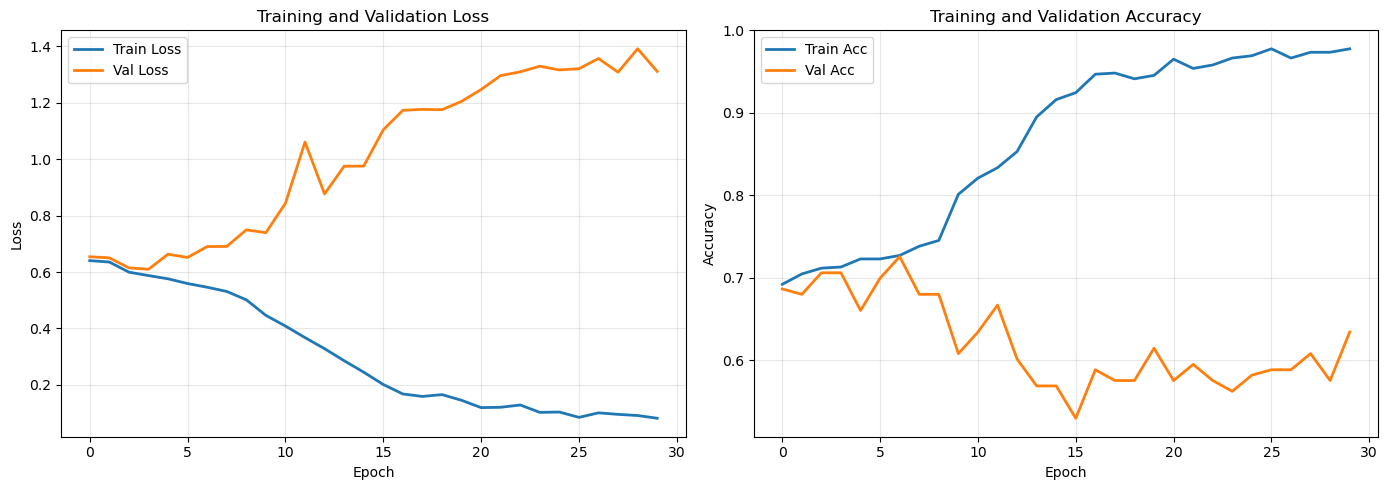

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc', linewidth=2)
ax2.plot(history['val_acc'], label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Load best model
model.load_state_dict(best_model_wts)

# Evaluate on test set
test_loss, test_acc, all_preds, all_labels = validate(model, test_loader, criterion)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

Validating: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.65s/it]


Test Accuracy: 0.7124
Test Loss: 0.6589

Classification Report:
              precision    recall  f1-score   support

      normal       0.72      0.97      0.83       109
    glaucoma       0.50      0.07      0.12        44

    accuracy                           0.71       153
   macro avg       0.61      0.52      0.47       153
weighted avg       0.66      0.71      0.62       153



In [21]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display in classic table format
print("=" * 80)
print("CONFUSION MATRIX - Classic Format")
print("=" * 80)

for i, class_name in enumerate(CLASS_NAMES):
    # For each class as positive:
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - TP - FN - FP
    
    print(f"\nClass: {class_name.upper()}")
    print("-" * 80)
    print(f"{'':20} | {'Predicted Positive':20} | {'Predicted Negative':20}")
    print("-" * 80)
    print(f"{'Actual Positive':20} | {'TP: ' + str(TP):20} | {'FN: ' + str(FN):20}")
    print(f"{'Actual Negative':20} | {'FP: ' + str(FP):20} | {'TN: ' + str(TN):20}")
    print("-" * 80)
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}")

print("\n" + "=" * 80)

CONFUSION MATRIX - Classic Format

Class: NORMAL
--------------------------------------------------------------------------------
                     | Predicted Positive   | Predicted Negative  
--------------------------------------------------------------------------------
Actual Positive      | TP: 106              | FN: 3               
Actual Negative      | FP: 41               | TN: 3               
--------------------------------------------------------------------------------
Precision: 0.7211 | Recall: 0.9725 | F1-Score: 0.8281

Class: GLAUCOMA
--------------------------------------------------------------------------------
                     | Predicted Positive   | Predicted Negative  
--------------------------------------------------------------------------------
Actual Positive      | TP: 3                | FN: 41              
Actual Negative      | FP: 3                | TN: 106             
-------------------------------------------------------------------------

In [22]:
# Create output directory
os.makedirs('outputs/models', exist_ok=True)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': CLASS_NAMES,
    'val_acc': best_acc,
    'test_acc': test_acc
}, 'outputs/models/glaucoma_model.pth')

print("Model saved to outputs/models/glaucoma_model.pth")

Model saved to outputs/models/glaucoma_model.pth
